In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import json
import boto3, botocore

In [2]:
def prep_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height,width = img.shape[0], img.shape[1]

    top_pad = bot_pad = height % 640 // 2
    left_pad = right_pad = width % 640 // 2

    img_padded = cv2.copyMakeBorder(img, top_pad, bot_pad, left_pad, right_pad, cv2.BORDER_CONSTANT, value=[114,114,114])
    img_padded_and_resized = cv2.resize(img_padded,(640,640))
    #calculate border padding

    #img = cv2.resize(img, (4032,3040))

    #plt.imshow(img_padded_and_resized)
    return img_padded_and_resized

In [13]:
new_img = prep_image('../examples/test.jpg')

(-0.5, 639.5, 639.5, -0.5)

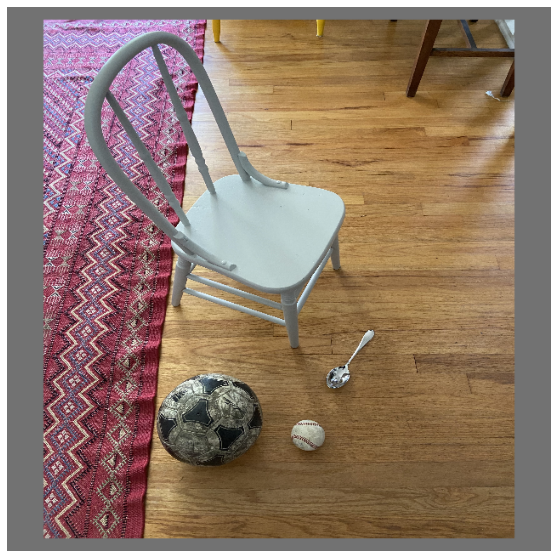

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(new_img)
plt.axis('off')

In [5]:
config = botocore.config.Config(read_timeout=500)
runtime = boto3.client('runtime.sagemaker', config=config)

In [6]:
data = np.array(new_img.astype(np.float16)/255.)
payload = json.dumps([data.tolist()])

response = runtime.invoke_endpoint(EndpointName='checkride-demo-yolov5l', ContentType='application/json', Body=payload)



In [7]:
result = json.loads(response['Body'].read().decode())


In [8]:
indices = np.where(np.array(result['predictions'][0]['output_1']) > 0.5)
xywh = np.array(result['predictions'][0]['output_0'])[indices]
xywh[:,0] *= 640
xywh[:,1] *= 640
xywh[:,2] *= 640
xywh[:,3] *= 640
xywh = xywh.astype(int)

scores = np.array(result['predictions'][0]['output_1'])[indices]
classes = np.array(result['predictions'][0]['output_2'])[indices]

In [9]:
class_names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush'] 

In [10]:
FONT = cv2.FONT_HERSHEY_SIMPLEX
FONTSCALE = .6
WHITE = (255, 255, 255)
THICKNESS = 2
for idx, rect in enumerate(xywh):
    img = cv2.rectangle(new_img,
              (rect[0], rect[1]-5),
              (rect[2], rect[3]), thickness=2, color = (255,0,0))
    
    class_idx = int(classes[idx])
    img = cv2.putText(img, 
                      f'{class_names[class_idx]}: {scores[idx]:0.3f}',
                      (rect[0],rect[1]),
                      FONT,
                      FONTSCALE,
                      WHITE,
                      THICKNESS)

(-0.5, 639.5, 639.5, -0.5)

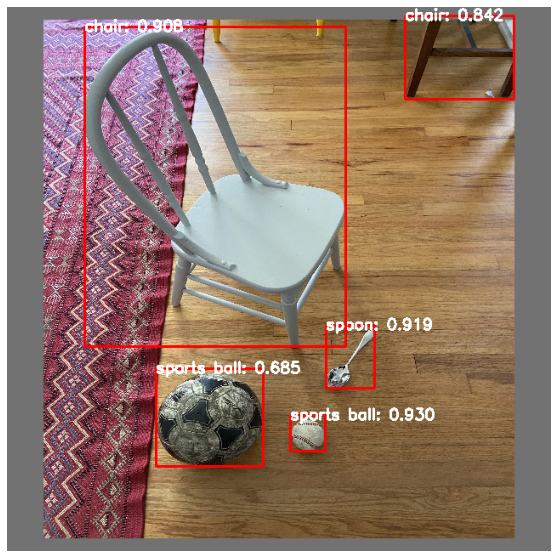

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('off')